### Notebook setup

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 10)

### Datasets

| Dataset             | Comment                                           | Size (clicks/size)  |
|---------------------|---------------------------------------------------|---------------------|
| train.csv           | the training set                                  | 57.537.506 / 2.5 GB |
| test.csv            | the test set                                      | 18.790.469 / 824 MB |
| test_supplement.csv | larger test set, subset used for Kaggle evaluation | 57.537.505 / 2.5GB  |


Every click record has following associated fields:
- click_time: timestamp of click (UTC)
- ip: ip address of click
- device: device type of user mobile phone
- os: os version id of user mobile phone
- channel: channel id of mobile ad publisher
- app: app id for marketing

Training data contains two additional fields:
- is_attributed: was app downloaded, to be predicted
- attributed_time: time of app download

For the given click data, the goal is to output the probability that the user will download the app.


In [5]:
dataset_train = pd.read_csv('data/mnt/ssd/kaggle-talkingdata2/competition_files/train.csv', nrows = 100000)
dataset_test = pd.read_csv('data/test.csv')

In [22]:
train_y = dataset_train['is_attributed']
train_X = dataset_train.drop(['is_attributed', 'attributed_time', 'click_time'], axis = 1)

test_ids = dataset_test['click_id']
test_X = dataset_test.drop(['click_id', 'click_time'], axis = 1)

### Data exploration

In [18]:
dataset_train.describe()

,ip,app,device,os,channel,is_attributed
count,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08
mean,9.087604e+04,1.201131e+01,2.172325e+01,2.267702e+01,2.685789e+02,2.470721e-03
std,6.952789e+04,1.480521e+01,2.593326e+02,5.525282e+01,1.295882e+02,4.964491e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.024500e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.400000e+02,0.000000e+00
50%,7.962200e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.580000e+02,0.000000e+00
75%,1.182470e+05,1.500000e+01,1.000000e+00,1.900000e+01,3.790000e+02,0.000000e+00
max,3.647780e+05,7.680000e+02,4.227000e+03,9.560000e+02,5.000000e+02,1.000000e+00


In [19]:
for col in dataset_train:
    print(col, dataset_train[col].nunique())

ip 277396
app 706
device 3475
os 800
channel 202
click_time 259620
attributed_time 182057
is_attributed 2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a245208>,
      dtype=object)

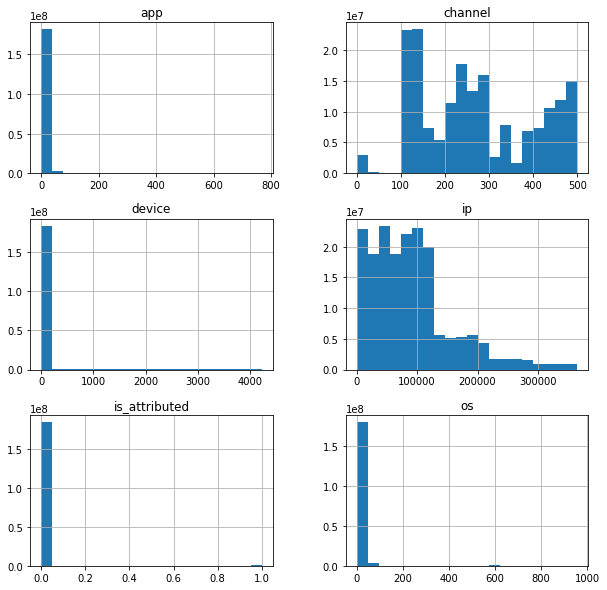

In [25]:
dataset_train.hist(bins=20, figsize=(10,10))

Distribution of `is_attributed` feature shows heavily unbalanced dataset towards no download cases.

In [29]:
corr = dataset_train.corr()
corr.style.background_gradient()

,ip,app,device,os,channel,is_attributed
ip,1,0.00664393,-0.000925784,-0.000189594,0.00439136,0.0538333
app,0.00664393,1,0.255865,0.25596,-0.0280314,0.0597225
device,-0.000925784,0.255865,1,0.939909,-0.0345028,0.00193645
os,-0.000189594,0.25596,0.939909,1,-0.031511,0.0016299
channel,0.00439136,-0.0280314,-0.0345028,-0.031511,1,-0.0241333
is_attributed,0.0538333,0.0597225,0.00193645,0.0016299,-0.0241333,1


### Algorithms and Techniques

### Benchmark models

For benchmark we will consider two models, one outputing constant value and second using random value from uniform distribution. Both will be evaluated on test set and the one with higher score will be used as basline.

In [9]:
benchmark_const = test[['click_id']].copy()
benchmark_const['is_attributed'] = 0
display(benchmark_const)

,click_id,is_attributed
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
18790464,18790464,0
18790465,18790465,0
18790466,18790467,0
18790467,18790466,0


In [10]:
benchmark_rand = dataset_test[['click_id']].copy()
benchmark_rand['is_attributed'] = np.random.uniform(size=len(benchmark_rand))
display(benchmark_rand)

,click_id,is_attributed
0,0,0.089253
1,1,0.851943
2,2,0.576291
3,3,0.014140
4,4,0.587584
...,...,...
18790464,18790464,0.744350
18790465,18790465,0.858212
18790466,18790467,0.796023
18790467,18790466,0.099114


In [33]:
# Save benchmarks for evaluation on Kaggle
# benchmark_const.to_csv('data/benchmark_const.csv.gz',compression='gzip', index=False)
# benchmark_rand.to_csv('data/benchmark_rand.csv.gz',compression='gzip', index=False)

Constant model that predicts no app download scores 0.5 on Kaggle evaluator. Random model that uses uniform distribution scores 0.4995 as private score (82% of test data) and 0.5003 as public score (18% of the test data). One approach to this problem is done by [Elior Tal](https://rpubs.com/el16/410747) and his solution scores 0.825 on a subset of the test set. In his work he compares performance of random forest and boosting algorithms. We will use this as a benchmark model as it is well documented and scores better than our initial baseline models. Additionally we will use existing Kaggle solutions on the [leaderboard](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/leaderboard ) as a supporting benchmark.

### Data preprocessing

Additional features that we will consider adding:
- for each attribute number of clicks in previous N minutes with same attribute
value
- for each attribute time since last click with same attribute value

In [23]:
# train_X['click_time'] = pd.to_datetime(train_X['click_time'])

### Model training

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Model evaluation

In [39]:
test_y = logreg.predict_proba(test_X)

In [34]:
test_result = pd.DataFrame(test_y)

In [47]:
test_result = pd.DataFrame(test_y[:,1], columns=['is_attributed'])
test_result['click_id'] = test_ids

test_result.to_csv('data/test_result.csv.gz',compression='gzip', index=False)

KeyboardInterrupt: 